# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [2]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [5]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        #print("HI2")
        super().__init__()
        #print("HI3")
        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

        self.Xmeans = None
        self.to(self.device)

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()


### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [6]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [7]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cpu


In [8]:
len(np.unique(Ttrain))

10

In [9]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

KeyboardInterrupt: 

In [10]:
cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)



In [12]:
print(type(cnnet))


<class '__main__.CNN2D'>


In [7]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [8]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 94.30


,0,1,2,3,4,5,6,7,8,9
0,96.938776,0.000000,0.510204,0.102041,0.306122,0.408163,0.714286,0.612245,0.204082,0.204082
1,0.000000,96.387665,0.352423,0.704846,0.176211,0.000000,0.352423,0.000000,1.938326,0.088106
2,0.872093,0.290698,93.992248,1.937984,0.096899,0.387597,0.484496,0.968992,0.678295,0.290698
3,0.000000,0.099010,1.287129,95.841584,0.000000,0.495050,0.000000,0.891089,0.891089,0.495050
4,0.305499,0.610998,0.305499,0.000000,95.926680,0.000000,0.509165,0.203666,0.203666,1.934827
5,0.336323,0.000000,0.112108,3.811659,0.000000,92.152466,1.121076,0.560538,1.793722,0.112108
6,1.774530,0.208768,0.313152,0.104384,0.208768,1.252610,95.198330,0.000000,0.939457,0.000000
7,0.389105,0.583658,2.042802,1.750973,0.680934,0.000000,0.000000,92.217899,0.000000,2.334630
8,1.026694,0.513347,0.718686,1.642710,0.205339,1.232033,0.821355,0.513347,91.581109,1.745380
9,0.891972,0.297324,0.099108,0.594648,1.982161,0.594648,0.099108,1.585728,1.486620,92.368682


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 2.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

adam: Epoch 2 Loss 0.569
adam: Epoch 4 Loss 0.376
adam: Epoch 6 Loss 0.293
adam: Epoch 8 Loss 0.277
adam: Epoch 10 Loss 0.258
adam: Epoch 12 Loss 0.243
adam: Epoch 14 Loss 0.220
adam: Epoch 16 Loss 0.215
adam: Epoch 18 Loss 0.219
adam: Epoch 20 Loss 0.210
Train accuracy in percent correct:93.16 
Test accuracy in percent correct: 92.67


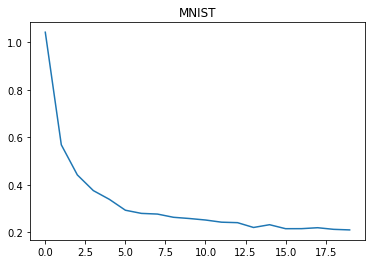

In [9]:
n_hiddens_per_conv_layer = [10]
patch_size_per_conv_layer = [5]
stride_per_conv_layer=[2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

classes_train, _ = cnnet.use(Xtrain)
perc_correct_Train1 = 100 * np.mean(classes_train == Ttrain)
print(f'Train accuracy in percent correct:{perc_correct_Train1:.2f} ')

Classes, _ = cnnet.use(Xtest)
perc_correct_Test1 = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct_Test1:.2f}')

In [10]:
n_hiddens_per_conv_layer = [10,10]
patch_size_per_conv_layer = [5,5]
stride_per_conv_layer=[2,2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

classes_train, _ = cnnet.use(Xtrain)
perc_correct_Train2 = 100 * np.mean(classes_train == Ttrain)
print(f'Train accuracy in percent correct:{perc_correct_Train2:.2f} ')

Classes, _ = cnnet.use(Xtest)
perc_correct_Test2 = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct_Test2:.2f}')

adam: Epoch 2 Loss 0.487


KeyboardInterrupt: 

In [ ]:
data ={'perc_correct_Train':[perc_correct_Train1,perc_correct_Train2],'perc_correct_Test':[perc_correct_Test1,perc_correct_Test2],
       'n_hiddens_per_conv_layer':[[10],[10,10]],'patch_size_per_conv_layer':[[5],[5,5]],'stride_per_conv_layer':[[2],[2,2]],
       'n_hiddens_per_fc_layer':[[5],[5]]
      }

In [ ]:
df = pandas.DataFrame(data)

In [ ]:
df

In [ ]:
n_hiddens_per_conv_layer = [10,10,10]
patch_size_per_conv_layer = [5,5,5]
stride_per_conv_layer=[1,1,1]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

classes_train, _ = cnnet.use(Xtrain)
perc_correct_Train3 = 100 * np.mean(classes_train == Ttrain)
print(f'Train accuracy in percent correct:{perc_correct_Train3:.2f} ')

Classes, _ = cnnet.use(Xtest)
perc_correct_Test3 = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct_Test3:.2f}')

In [ ]:
n_hiddens_per_conv_layer = [10,10]
patch_size_per_conv_layer = [5,5]
stride_per_conv_layer=[2,2]
n_hiddens_per_fc_layer = []

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')
Classes, _ = cnnet.use(Xtest)
perc_correct_2a = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct_2a:.2f}')

In [ ]:
n_hiddens_per_conv_layer = [10,10]
patch_size_per_conv_layer = [5,5]
stride_per_conv_layer=[2,2]
n_hiddens_per_fc_layer = [10]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')
Classes, _ = cnnet.use(Xtest)
perc_correct_2b = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct_2b:.2f}')

In [ ]:
n_hiddens_per_conv_layer = [10,10]
patch_size_per_conv_layer = [5,5]
stride_per_conv_layer=[2,2]
n_hiddens_per_fc_layer = [10,10]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')
Classes, _ = cnnet.use(Xtest)
perc_correct_2c = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct_2c:.2f}')

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `__init__` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately.
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [ ]:
class CNN1D(CNN2D):
    
    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):
        
    
        #print("HI1")
        
        super().__init__(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer,
        n_outputs, patch_size_per_conv_layer, stride_per_conv_layer, activation_function, device)
        #print("yes")
        #1/0

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        #print(n_conv_layers)
        
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('Then lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        
        input_hw = int(n_inputs)  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

        self.Xmeans = None
        self.to(self.device)

    def forward_all_outputs(self, X):
        
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()
   
    

In [ ]:
%run -i A5grader.py

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values, with zeros between the waves long.

In [17]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [18]:
make_square_pulse()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

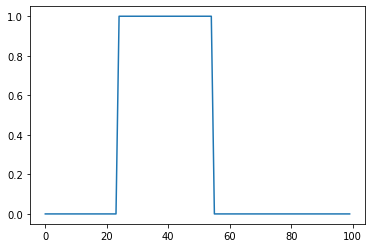

In [19]:
plt.plot(make_square_pulse());

In [20]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

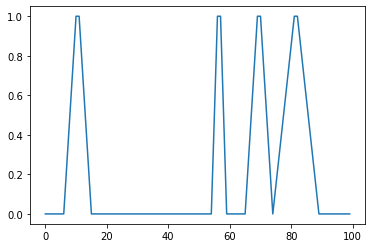

In [21]:
plt.plot(make_triangular_pulse());

In [22]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [23]:
np.newaxis == None

True

In [24]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [25]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtrain.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.688
adam: Epoch 20 Loss 0.564
adam: Epoch 30 Loss 0.375
adam: Epoch 40 Loss 0.111
adam: Epoch 50 Loss 0.035
adam: Epoch 60 Loss 0.005
adam: Epoch 70 Loss 0.002
adam: Epoch 80 Loss 0.001
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

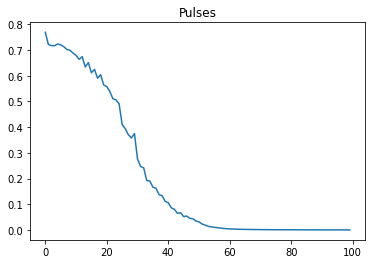

In [26]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)


n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [27]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 100.00


,square,triangular
square,100.0,0.0
triangular,0.0,100.0


torch.Size([10, 10])

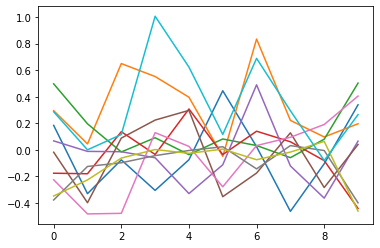

In [28]:
W = list(cnnet1.children())[0][0].weight.data
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~anderson/cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [29]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

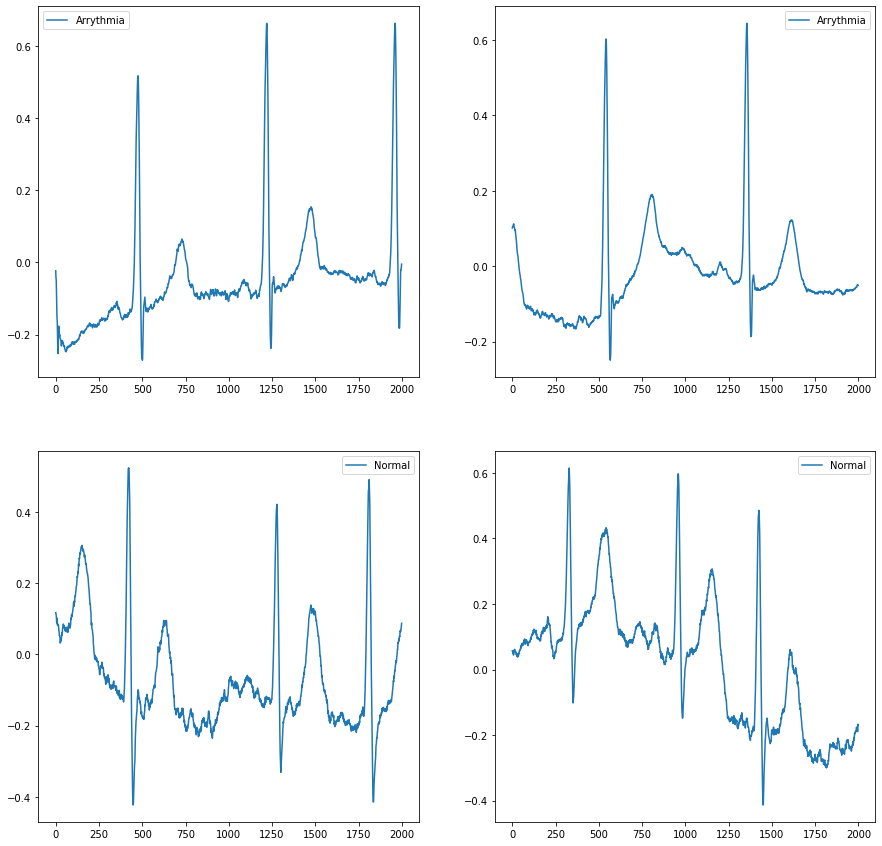

In [30]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [31]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [32]:
Ttrain

array([['nr'],
       ['arr'],
       ['nr'],
       ...,
       ['arr'],
       ['nr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [40]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)

In [41]:
cnn1d

CNN1D(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 5, kernel_size=(100,), stride=(20,))
    (1): Conv1d(5, 10, kernel_size=(20,), stride=(5,))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=160, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [49]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'A5 -CNN1D PYTORCH.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mea

In [35]:
run_my_solution = False

import os
import copy
import signal
import os
import numpy as np

if run_my_solution:
    from A4mysolution import *
    # print('##############################################')
    # print("RUNNING INSTRUCTOR's SOLUTION!!!!!!!!!!!!")
    # print('##############################################')

else:
    
    print('\n======================= Code Execution =======================\n')

    assignmentNumber = '5'

    import subprocess, glob, pathlib
    nb_name = '*A{}*.ipynb'
    # nb_name = '*.ipynb'
    filename = next(glob.iglob(nb_name.format(assignmentNumber)), None)
    print('Extracting python code from notebook named \'{}\' and storing in notebookcode.py'.format(filename))
    if not filename:
        raise Exception('Please rename your notebook file to <Your Last Name>-A{}.ipynb'.format(assignmentNumber))
    with open('notebookcode.py', 'w') as outputFile:
        subprocess.call(['jupyter', 'nbconvert', '--to', 'script',
                         nb_name.format(assignmentNumber), '--stdout'], stdout=outputFile)
    # from https://stackoverflow.com/questions/30133278/import-only-functions-from-a-python-file
    import sys
    import ast
    import types
    with open('notebookcode.py') as fp:
        tree = ast.parse(fp.read(), 'eval')
    print('Removing all statements that are not function or class defs or import statements.')
    for node in tree.body[:]:
        if (not isinstance(node, ast.FunctionDef) and
            not isinstance(node, ast.Import) and
            not isinstance(node, ast.ClassDef)):
            # not isinstance(node, ast.ImportFrom)):
            tree.body.remove(node)
    # Now write remaining code to py file and import it
    module = types.ModuleType('notebookcodeStripped')
    code = compile(tree, 'notebookcodeStripped.py', 'exec')
    sys.modules['notebookcodeStripped'] = module
    exec(code, module.__dict__)
    # import notebookcodeStripped as useThisCode
    from notebookcodeStripped import *


    
exec_grade = 0

for func in ['CNN2D', 'CNN1D']:
    if func not in dir() or not callable(globals()[func]):
        print('CRITICAL ERROR: Function named \'{}\' is not defined'.format(func))
        print('  Check the spelling and capitalization of the function name.')

            
print('''\nTesting

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.use(Xtrain)[0] == Ttrain)
    perc_test = 100 * np.mean(cnn1d.use(Xtest)[0] == Ttest)
''')


try:
    pts = 80

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.use(Xtrain)[0] == Ttrain)
    perc_test = 100 * np.mean(cnn1d.use(Xtest)[0] == Ttest)

    pts = pts // 2

    if perc_train == 100:
        exec_grade += pts
        print(f'\n--- {pts}/{pts} points.  perc_train is correctly 100%.')
    else:
        print(f'\n---  0/{pts} points. perc_train should be 100%.  Your value is {perc_train}')

    if perc_train == 100:
        exec_grade += pts
        print(f'\n--- {pts}/{pts} points.  perc_test is correctly 100%.')
    else:
        print(f'\n---  0/{pts} points. perc_test should be 100%.  Your value is {perc_test}')

except Exception as ex:
    print(f'\n--- 0/{pts} points. Raises exception:')
    print(ex)
        




name = os.getcwd().split('/')[-1]

print()
print('='*70)
print('{} Execution Grade is {} / 80'.format(name, exec_grade))
print('='*70)


print('''\n __ / 10 Based on results of experiments with MNIST data.''')
print('''\n __ / 10 Based on results of experiments with ECG data.''')

print()
print('='*70)
print('{} FINAL GRADE is  _  / 100'.format(name))
print('='*70)

print('''
Extra Credit:

Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments.

1. Compare your results on the MNIST data by using relu versus tanh activation functions. Show and 
   discuss the results.

2. Compare your results on the MNIST data using adam versus sgd. Show and discuss the results.

3. Download another image data set, apply your CNN2D class to this data and discuss the results.''')

print('\n{} EXTRA CREDIT is 0 / 3'.format(name))

if run_my_solution:
    # print('##############################################')
    # print("RUNNING INSTRUCTOR's SOLUTION!!!!!!!!!!!!")
    # print('##############################################')
    pass




======================= Code Execution =======================

Extracting python code from notebook named 'A5 -CNN1D PYTORCH.ipynb' and storing in notebookcode.py


SyntaxError: invalid syntax (eval, line 1173)

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.